# Homework 2 Solutions

## Overview

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [1]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 30 Points)

### Problem 1 (5 points)

The systems diagram should look like this:

<figure>
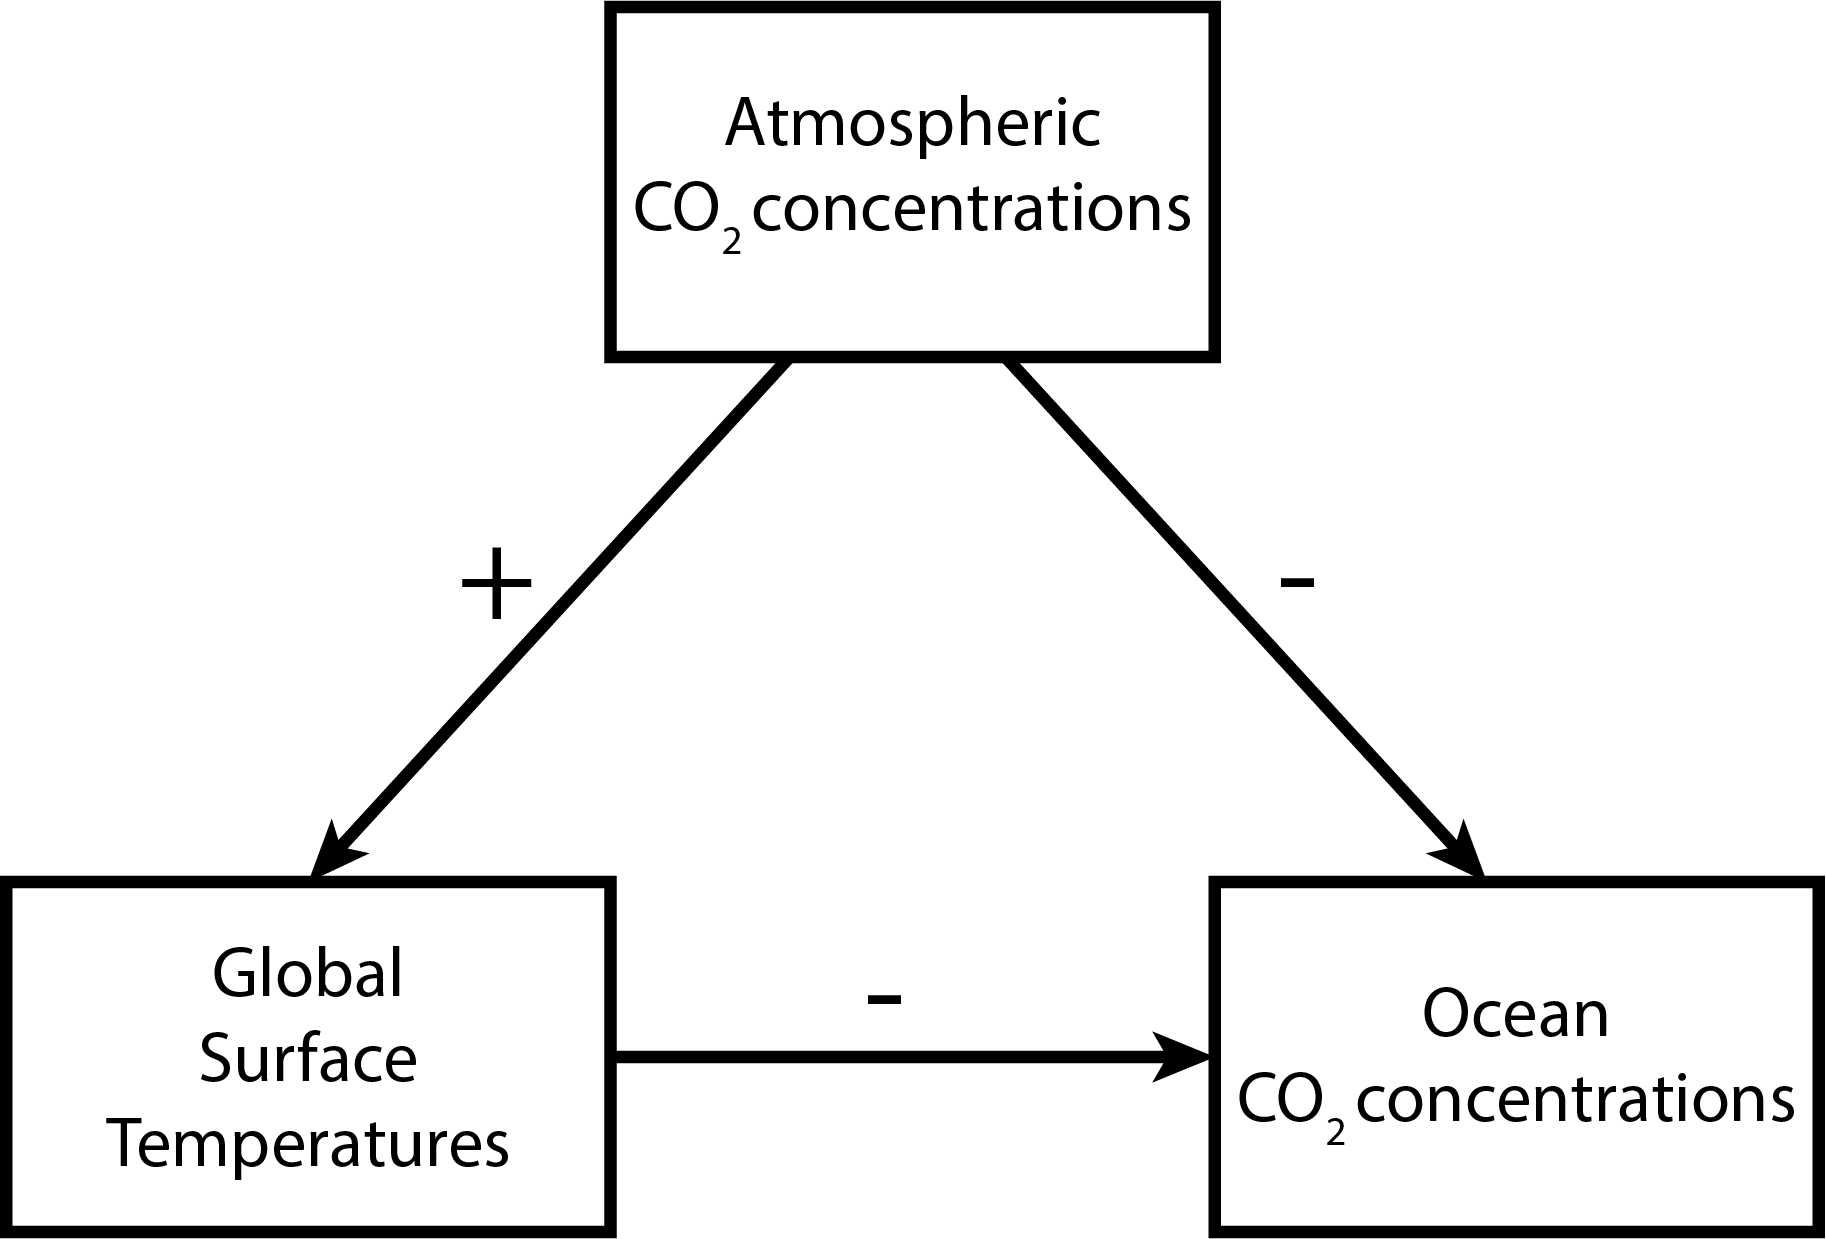
<figcaption aria-hidden="true">Systems Diagram for Problem
1</figcaption>
</figure>

-   The positive connection between atmospheric CO<sub>2</sub>
    concentrations and global temperatures is just capturing the
    greenhouse effect: CO<sub>2</sub> blocks the transmission of
    radiation along certain frequencies which would normally cause a
    loss of energy back to space.
-   The negative connection between global temperatures and ocean
    CO<sub>2</sub> concentrations is a result of Henry’s law for the
    solubility of CO<sub>2</sub>. While the oceans are not an ideal
    mixture and the atmospheres and oceans aren’t in equilibrium (so one
    would be cautious in using Henry’s law to make specific predictions
    about concentrations), the key insight is the temperature dependence
    of Henry’s constant, where increasing temperature decreases
    solubility.
-   The negative connection between ocean and atmospheric CO<sub>2</sub>
    concentrations is the result of the mass balance of CO<sub>2</sub>:
    CO<sub>2</sub> which degasses from the oceans must end up in the
    atmosphere, and the uptake of CO<sub>2</sub> from the oceans must
    come from the atmosphere.

The overall feedback is therefore amplifying: increases in temperature
decrease the concentration of CO<sub>2</sub> in oceans, which increase
the atmospheric concentration, causing further temperature increases.

### Problem 2 (15 points)

#### Problem 2.1

This is a two box (or two control volume) model, as there is a change in
the mass-balance at the second wastewater discharge. As a result, the
relevant diagram might look like this:

<figure>
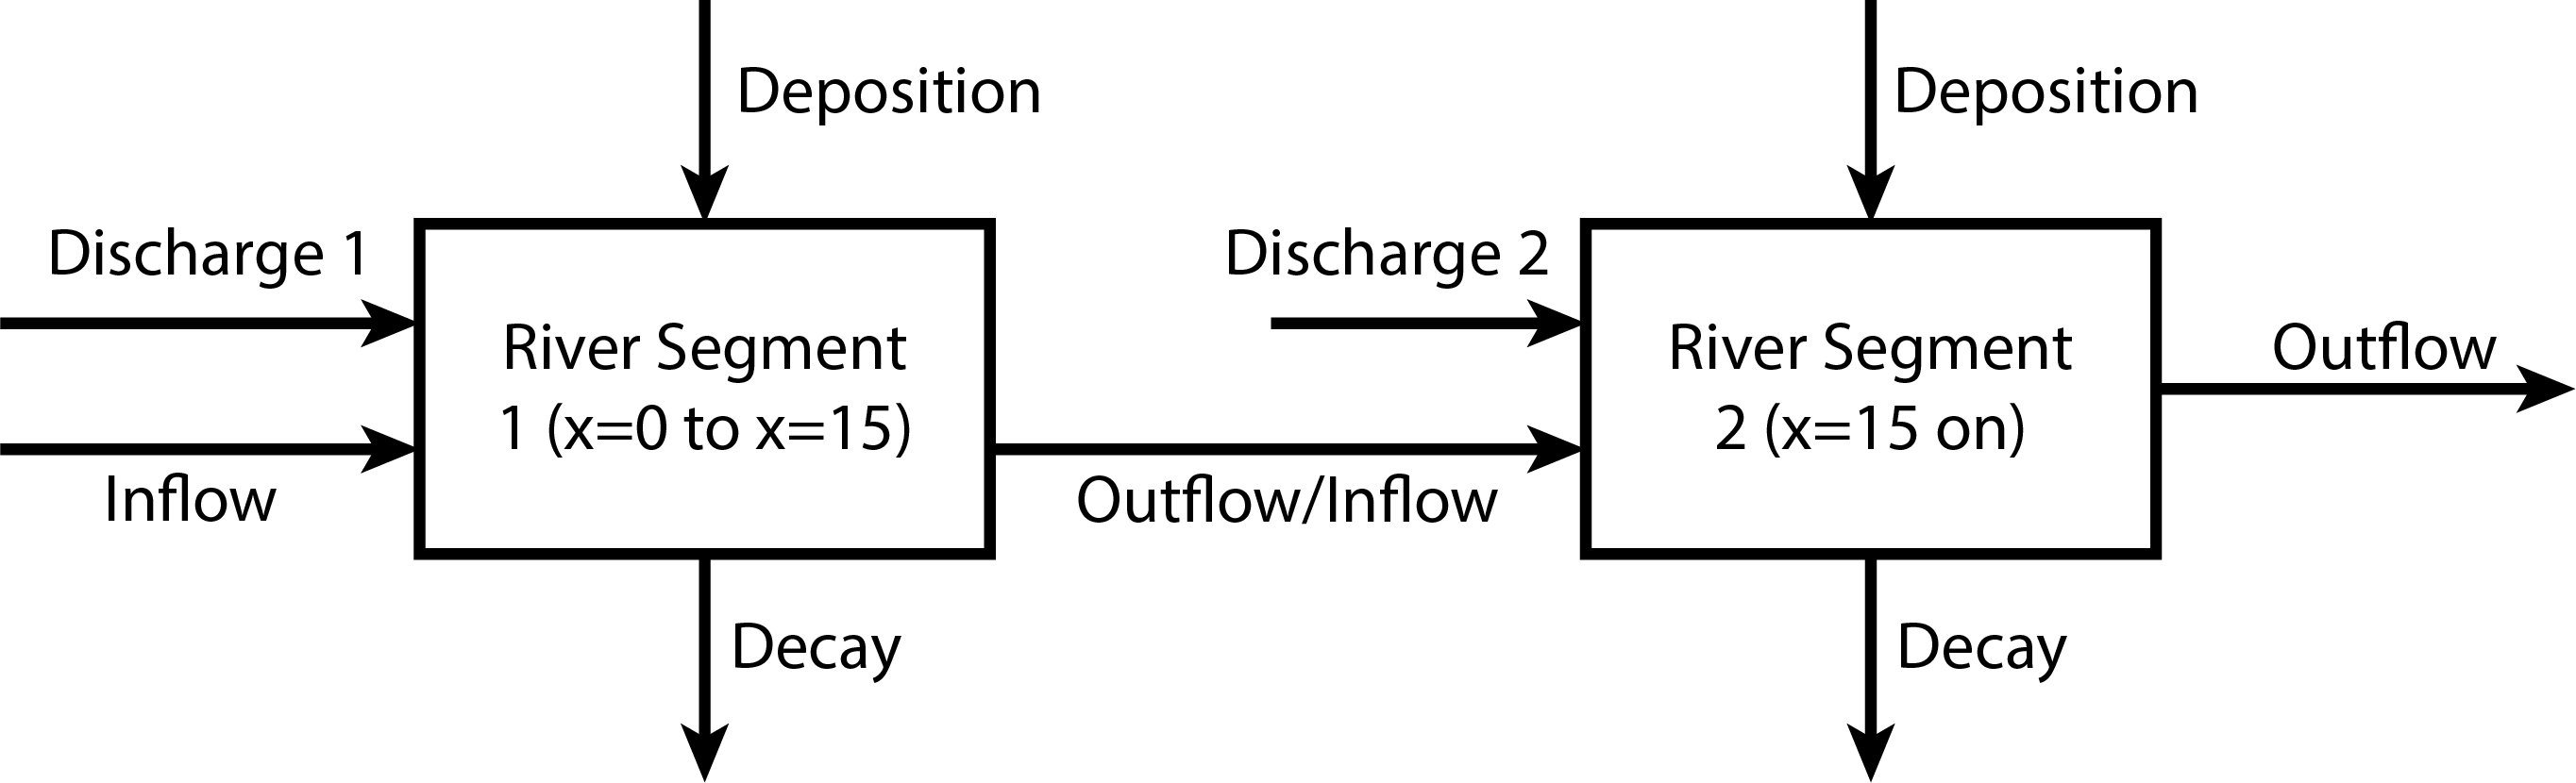
<figcaption aria-hidden="true">Schematic of the sources and sinks for
the two-box river model.</figcaption>
</figure>

#### Problem 2.2

CRUD decays exponentially at a rate of $0.36\ \mathrm{d}^{-1}$ and is
deposited at a rate of $54\ \text{kg}/\text{km}/\text{d}$, so the
differential equation for its mass $M$ as a function of time is
$$\frac{dM}{dt} = -0.36M + 54 \times 10.$$

By separating variables, the solution to this equation is
$$M(t) = M_0 \exp(-0.36t) + 1500\left(1-\exp(-0.36t)\right),$$ where
$M_0$ is the initial condition in each box. However, we need to convert
time $t$ (d) to distance $x$ (km) as the discharges are constant in time
and given in terms of spatial distance rather than time. As the velocity
of the river is $10\ \mathrm{km/d}$, $$t = \frac{x}{10},$$ so
<span id="eq-river-1">$$M(x) = M_0 \exp(-0.36x/10)  + 1500\left(1-\exp(-0.36x/10)\right). \qquad(1)$$</span>

We need to find the initial conditions at the entry to each box. The
first segment goes from $x=0$ (the first wastewater discharge) to $x=15$
(the second discharge), and the initial condition satisfies
$M_0 = M(0)$. To calculate this mass, we have to compute the total mass
of CRUD in the combined inflow and wastewater discharge, which is

The second segment starts at $x=15$ and follows the equation
$$M(x) = M_1 \exp(-0.36(x-15)/10) + 1500\left(1-\exp(-0.36(x-15)/10)\right), \qquad x \leq 15.$$
The outflowing mass of the first box (evaluating
<a href="#eq-river-1" class="quarto-xref">Equation 1</a> at $x=15$) is
approximately $909 kg$, so the initial condition at the second box is:

<span id="eq-river-2">$$
M(t) = \begin{cases} 485 \exp(-0.36x/10) + 1500\left(1-\exp(-0.36x/10)\right), &\text{if}\ 0 \leq x < 15 \\
                    1329 \exp(-0.36(x-15)/10) + 1500\left(1-\exp(-0.36(x-15)/10)\right), & \text{if}\ x > 15.
\end{cases}
 \qquad(2)$$</span>

#### Problem 2.3

To see if the river will be in compliance with a standard of
$2.3\ \text{kg}/(1000\text{m}^3)$, we need to find the maximum value of
<a href="#eq-river-2" class="quarto-xref">Equation 2</a>.

Plotting concentration over distance (we need to evaluate a bit
downstream from the second discharge to be sure the atmospheric
deposition won’t cause the river to go out of compliance before the CRUD
in the river can decay sufficiently, so we’ll plot from $x=0$ to
$25\ \text{km}$):

In [1]:
# this function will return concentration in terms of kg/(1000 m^3)
function yuk_concentration(x)
    if x < 15
        M = 485 * exp(-0.36 * x / 10) + 1500 * (1 - exp(-0.36 * x /10 ))
        C = M / 290 
    else
        M = 1329 * exp(-0.36 * (x - 15) / 10) + 1500 * (1 - exp(-0.36 * (x - 15) /10 ))
        C = M / 350
    end
    return C
end

x = 0:25
yuk = yuk_concentration.(x)
p = plot(x, yuk, color=:black, linewidth=2, label="YUK")
hline!(p, [2.3], color=:red, linestyle=:dash, label="Standard")
xlabel!(p, "Distance (km)")
ylabel!(p, "Concentration (kg/1000 m³)")

We can see that the river is not in compliance.

### Problem 3 (10 points)

#### Problem 3.1

The climate model (neglecting the greenhouse gas term) is:

<span id="eq-climate">$$
C\frac{dT}{dt} = \frac{(1-\alpha)S}{4} - (A - BT)
 \qquad(3)$$</span>

Discretizing with forward Euler involves replacing $\frac{dT}{dt}$ with
$\frac{T(t+\Delta t) - T(t)}{\Delta t}$ for some sufficiently small time
step $\Delta t$. With this substitution and rearrangement,
<a href="#eq-climate" class="quarto-xref">Equation 3</a> becomes:

<span id="eq-climate-discretize">$$
T(t + \Delta t) = T(t) + \frac{\Delta t}{C}\left(\frac{(1-\alpha)S}{4} - (A - BT(t))\right)
 \qquad(4)$$</span>

We will select $\Delta t = 1\ \text{yr}$, so
<a href="#eq-climate-discretize" class="quarto-xref">Equation 4</a>
becomes

<span id="eq-climate-discretize-2">$$
T(t + 1) = T(t) + \frac{1}{C}\left(\frac{(1-\alpha)S}{4} - (A - BT(t))\right)
 \qquad(5)$$</span>

#### Problem 3.2

Implementing the model (including the ice-albedo feedback):

In [1]:
# function for the temperature-dependent albedo
function albedo(T)
    if T < -10
        α = 0.5
    elseif T > 10
        α = 0.3
    else
        α = 0.5 + (0.3 - 0.5) * ((T + 10) / 20)
    end
    return α
end

# incoming radiation as a function of temperature T
# (for albedo) and solar constant S
function incoming_radiation(T, S)
    return (1 - albedo(T)) * S / 4
end

# outgoing radiation, using the coefficients A and B
# from the problem statement
function outgoing_radiation(T)
    B = -1.3 # in W/m^2/°C
    A = 221.2 # in W/m^2
    return A - B * T
end

# climate model simulation as a function of number of years N,
# solar constant S, and initial temperature T₀
function climate_model(N, S, T₀)
    C = 51.0 # heat capacity, J/m^2/°C
    T = zeros(N+1) # pre-initialize storage for temperatures
    T[1] = T₀
    for t = 1:N
        T[t+1] = T[t] + (incoming_radiation(T[t], S) - outgoing_radiation(T[t])) / C
    end
    return T
end

Now we generate a number of simulations for different initial values and
$S=1272\ \text{W}/\text{m}^2$:

In [1]:
init_T = -60:1:30
T = map(x -> climate_model(200, 1272, x), init_T)
p = plot(T, label=false, xlabel="Year", ylabel="Temperature (°C)")

We can see that with this solar constant, under this model the planet
will inevitably tend towards a frozen equilibrium of approximately
$-44^\circ \text{C}$ (it’s ok for this to not be exact so long as it’s
consistent with the plot). This is the only equilibrium and it is
stable.

#### Problem 3.3

If an increase in the solar constant was sufficient to warm the planet,
we should see a simulation beginning with the Neoproteorozoic
equilibrium of $-44^\circ \text{C}$ warm to a non-frozen temperature
with the modern solar constant. In reality, this transition would be
slower than just a sudden change in the solar constant to the modern
value, but if this simulation doesn’t result in the necessary level of
warming, a slower change in the solar constant would not be able to
explain the transition. We can see if this works by using our climate
model with the modern value of $S=1368\ \text{W}/\text{m}^2$ and
$T_0 = -44^\circ\text{C}$.

In [1]:
T = climate_model(1000, 1368, -44)
p = plot(T, label=false, xlabel="Year", ylabel="Temperature (°C)")

We can see that while this will result in the planet warming slightly
(to around $-39^\circ\text{C}$), it would not be enough to melt the ice
covering the planet. This would require some other shock, like a change
in CO<sub>2</sub> emissions (remember that we neglected the greenhouse
effect), which could have come from *e.g.* volcanic eruptions.

## References

List any external references consulted, including classmates.